In [1]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive
from torchvision.datasets import Cityscapes, DatasetFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools
from tqdm import tqdm
import os
import cv2
import glob
import pickle
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import VisionDataset
from PIL import Image
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from skimage import exposure
import torch.nn.functional as F
from torchvision.models import vgg16, VGG16_Weights



if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

CITYSCAPES_DIR = '/work/cvcs2024/fiorottandi/workspace/data/cityscapes/'
GTA_DIR = '/work/cvcs2024/fiorottandi/workspace/data/gta/'
CHECKPOINT_DIR = '/work/cvcs2024/fiorottandi/workspace/checkpoints/'

IMAGE_SIZE_X = 512
IMAGE_SIZE_Y = 960
BATCH_SIZE = 1
NUM_WORKERS = 1


Using GPU


In [2]:
#Define transformations for input images
input_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_X, IMAGE_SIZE_Y)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for target images
target_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_X, IMAGE_SIZE_Y)),
    transforms.ToTensor()
])


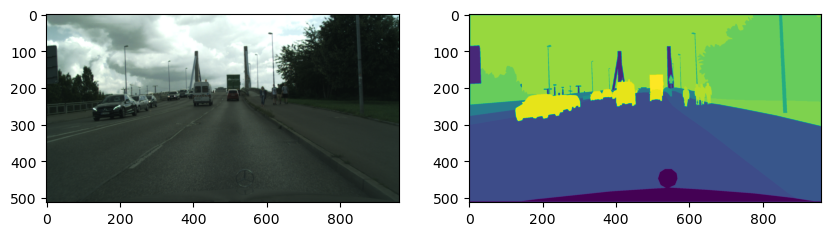

In [3]:
#Download cityscapes dataset and use transformations to resize the images to the right dimension
cityscapes = Cityscapes(CITYSCAPES_DIR, split='train', mode='fine', target_type='semantic', transform=input_transform, target_transform=target_transform)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = cityscapes[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))
plt.show()

cityscapes_loader = DataLoader(cityscapes, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

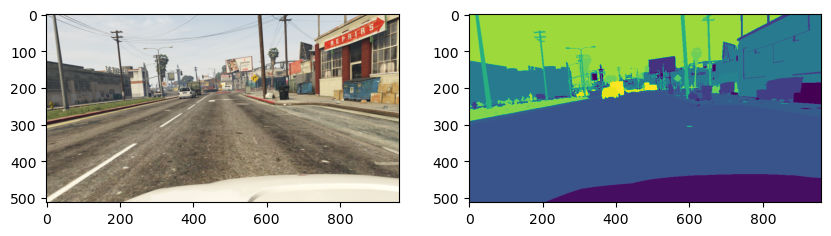

In [4]:
# GTADataset with resize transformations
class GTADataset(VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        super(GTADataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.image_dir = os.path.join(root, 'images')
        self.label_dir = os.path.join(root, 'labels')
        self.images = sorted(os.listdir(self.image_dir))
        self.labels = sorted(os.listdir(self.label_dir))
        assert len(self.images) == len(self.labels), "Mismatch between number of images and labels"

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.labels[index])
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.images)

gta = GTADataset(GTA_DIR, transform=input_transform, target_transform=target_transform)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = gta[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))
plt.show()

gta_loader = DataLoader(gta, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/tmp/ipykernel_417772/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)


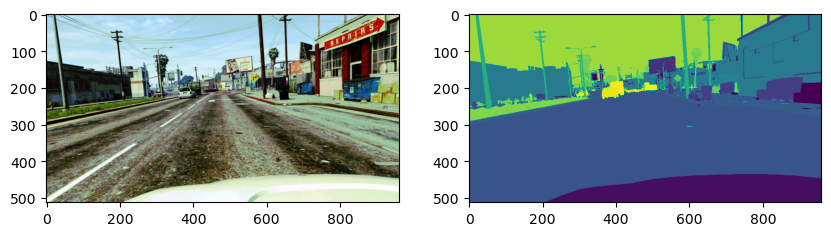

In [5]:
# Define histogram matching function
def match_histogram(image, reference):
    """Match the histogram of the image to the reference image."""
    matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)
    return Image.fromarray(matched)

# Load a few Cityscapes images to use as reference for histogram matching, converting them to RGB
reference_images = [transforms.ToPILImage()(cityscapes[i][0].clone()).convert('RGB') for i in range(10)]

# Define a new GTA dataset class with histogram matching
class GTADatasetWithHistogramMatching(VisionDataset):
    def __init__(self, root, reference_images, transform=None, target_transform=None):
        super(GTADatasetWithHistogramMatching, self).__init__(root, transform=transform, target_transform=target_transform)
        self.image_dir = os.path.join(root, 'images')
        self.label_dir = os.path.join(root, 'labels')
        self.images = sorted(os.listdir(self.image_dir))
        self.labels = sorted(os.listdir(self.label_dir))
        assert len(self.images) == len(self.labels), "Mismatch between number of images and labels"
        self.reference_images = reference_images

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.labels[index])
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        # Apply histogram matching
        reference_image = self.reference_images[index % len(self.reference_images)]
        image = match_histogram(image, reference_image)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.images)

# Load GTA dataset with histogram matching
gta_histogram_matched = GTADatasetWithHistogramMatching(GTA_DIR, reference_images, transform=input_transform, target_transform=target_transform)

# Display a sample from GTA after histogram matching
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = gta_histogram_matched[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))  
plt.show()

# DataLoader for GTA with histogram matching
gta_loader_histogram_matched = DataLoader(gta_histogram_matched, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


In [6]:
from torchvision.models import resnet18
'''
# Load pre-trained ResNet18 model and move it to the device (GPU)
model = resnet18(pretrained=True).to(device).eval()

def extract_features(data_loader, model, device):
    features = []
    with torch.no_grad():
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)  # Move images to the GPU
            feats = model(imgs).view(imgs.size(0), -1)
            feats = F.normalize(feats, dim=1)
            features.append(feats.cpu().numpy())  # Move back to CPU before storing to save memory
    return np.concatenate(features, axis=0)

# Extract features for Cityscapes and GTA datasets
cityscapes_features = extract_features(cityscapes_loader, model, device)
gta_features = extract_features(gta_loader_histogram_matched, model, device)

# Calculate cosine similarity in smaller batches to save memory
batch_size = 100  # Adjust this size based on your memory capacity
gta_to_cityscapes = []

for i in tqdm(range(0, gta_features.shape[0], batch_size)):
    end_i = min(i + batch_size, gta_features.shape[0])
    # Compute cosine similarity on CPU to avoid GPU memory overflow
    similarities = cosine_similarity(gta_features[i:end_i], cityscapes_features)
    gta_to_cityscapes.extend(np.argmax(similarities, axis=1))

# Save the paired indices
with open('/work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl', 'wb') as f:
    pickle.dump(gta_to_cityscapes, f)
'''
print('Paired dataset saved to /work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl')

Paired dataset saved to /work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl


In [7]:
with open('/work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl', 'rb') as f:
    gta_to_cityscapes = pickle.load(f) # A list or array that maps each GTA image (index) to the most similar Cityscapes image 

/tmp/ipykernel_417772/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


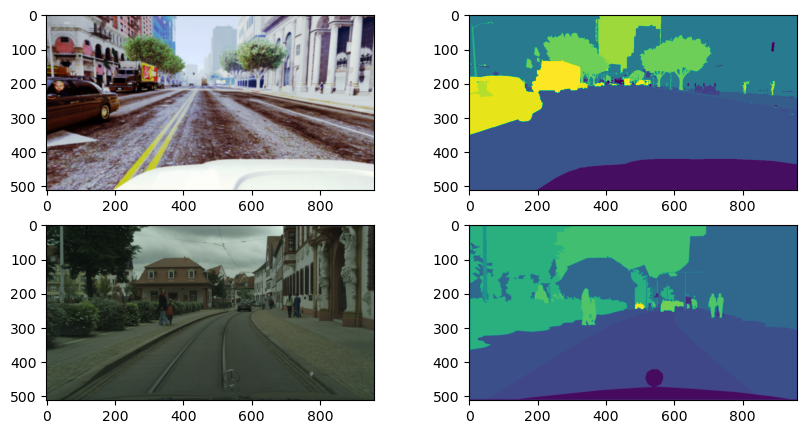

In [8]:
# Custom dataset class for paired GTA and Cityscapes images, with option to aplly the Bilateral Filter operator on gta for noise reduction
class PairedDataset(Dataset):
    def __init__(self, gta_dataset, cityscapes_dataset, gta_to_cityscapes, apply_bilateral=False):
        self.gta_dataset = gta_dataset
        self.cityscapes_dataset = cityscapes_dataset
        self.gta_to_cityscapes = gta_to_cityscapes
        self.apply_bilateral = apply_bilateral

    def __len__(self):
        return len(self.gta_to_cityscapes)

    def __getitem__(self, idx):
        gta_img, gta_seg = self.gta_dataset[idx]
        cityscapes_img, cityscapes_seg = self.cityscapes_dataset[self.gta_to_cityscapes[idx]]

        # Apply bilateral filtering if enabled
        if self.apply_bilateral:
            gta_img = self.apply_bilateral_filtering(gta_img)

        return gta_img, gta_seg, cityscapes_img, cityscapes_seg

    def apply_bilateral_filtering(self, image):
        # Convert torch tensor to numpy array, apply filtering, then convert back to tensor
        image_np = image.permute(1, 2, 0).numpy()
        filtered_image = cv2.bilateralFilter(image_np, d=5, sigmaColor=25, sigmaSpace=25)
        return torch.from_numpy(filtered_image).permute(2, 0, 1)

# Create the paired dataset
paired_dataset = PairedDataset(gta_histogram_matched, cityscapes, gta_to_cityscapes, apply_bilateral=True)
fix, ax = plt.subplots(2, 2, figsize=(10, 5))
i = 338
ax[0][0].imshow(paired_dataset[i][0].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[0][1].imshow(paired_dataset[i][1].permute(1, 2, 0))
ax[1][0].imshow(paired_dataset[i][2].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1][1].imshow(paired_dataset[i][3].permute(1, 2, 0))
plt.show()

In [ ]:
import random
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image

# Define the random affine transformation class
class RandomAffineTransform:
    def __init__(self, degrees, translate=None, scale=None, shear=None):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.shear = shear

    def __call__(self, sample):
        image_gta, label_gta, image_cityscapes, label_cityscapes = sample

        # Generate a random seed for reproducibility
        seed = random.randint(0, 2**32 - 1)
        random.seed(seed)
        np.random.seed(seed)
        
        # Randomly generate affine parameters
        angle = random.uniform(-self.degrees, self.degrees)
        translate = (random.uniform(-self.translate[0], self.translate[0]),
                     random.uniform(-self.translate[1], self.translate[1])) if self.translate else None
        scale = random.uniform(1 - self.scale, 1 + self.scale) if self.scale else 1
        shear = (random.uniform(-self.shear[0], self.shear[0]),
                 random.uniform(-self.shear[1], self.shear[1])) if self.shear else None

        # Apply affine transformation
        image_gta = TF.affine(image_gta, angle, translate, scale, shear)
        label_gta = TF.affine(label_gta, angle, translate, scale, shear, fill=0)
        image_cityscapes = TF.affine(image_cityscapes, angle, translate, scale, shear)
        label_cityscapes = TF.affine(label_cityscapes, angle, translate, scale, shear, fill=0)

        return image_gta, label_gta, image_cityscapes, label_cityscapes

# Function to split dataset while preserving correspondences
def split_dataset(paired_dataset, split_ratio=0.8):
    total_size = len(paired_dataset)
    indices = list(range(total_size))
    split = int(split_ratio * total_size)
    random.shuffle(indices)
    train_indices, test_indices = indices[:split], indices[split:]
    return train_indices, test_indices

# Assuming paired_dataset is the combined dataset with GTA and Cityscapes pairs
train_indices, test_indices = split_dataset(paired_dataset)

# Create subsets for training and testing while preserving the paired correspondences
train_dataset = torch.utils.data.Subset(paired_dataset, train_indices)
test_dataset = torch.utils.data.Subset(paired_dataset, test_indices)

# Define affine transformation parameters
affine_transform = RandomAffineTransform(degrees=10, translate=(0.1, 0.1), scale=0.1, shear=(0.1, 0.1))

# Custom dataset to apply affine transformation only to the training set
class DatasetWithAffine(Dataset):
    def __init__(self, paired_dataset, indices, affine_transform=None):
        self.paired_dataset = paired_dataset
        self.indices = indices
        self.affine_transform = affine_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        gta_img, gta_seg, cityscapes_img, cityscapes_seg = self.paired_dataset[actual_idx]

        if self.affine_transform:
            gta_img, gta_seg, cityscapes_img, cityscapes_seg = self.affine_transform(
                (gta_img, gta_seg, cityscapes_img, cityscapes_seg))

        return gta_img, gta_seg, cityscapes_img, cityscapes_seg

# Create training dataset with affine transformations
train_dataset_with_affine = DatasetWithAffine(
    paired_dataset=train_dataset,
    indices=list(range(len(train_dataset))),
    affine_transform=affine_transform
)

fix, ax = plt.subplots(2, 2, figsize=(10, 5))
i = 1
ax[0][0].imshow(train_dataset_with_affine[i][0].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[0][1].imshow(train_dataset_with_affine[i][1].permute(1, 2, 0))
ax[1][0].imshow(train_dataset_with_affine[i][2].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1][1].imshow(train_dataset_with_affine[i][3].permute(1, 2, 0))
plt.show()

# Create DataLoaders
train_loader = DataLoader(train_dataset_with_affine, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

print('DataLoaders created with affine transformations applied to the training set and no transformations for the test set.')
